# Сlothing classification

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439
Receiving objects: 100% (3839/3839), 100.58 MiB | 5.07 MiB/s, done.
Resolving deltas: 100% (10/10), done.


## Загрузка изображений

In [4]:
from tensorflow.keras.preprocessing.image import load_img

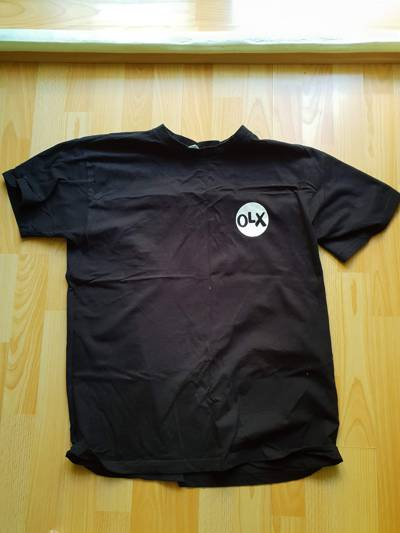

In [5]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = path + '/' + name
load_img(fullname)

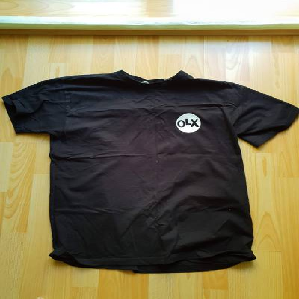

In [6]:
# Чтобы изменить размер, необходимо указать target_size

load_img(fullname, target_size=(299, 299))

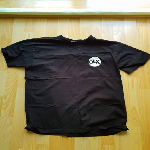

In [7]:
load_img(fullname, target_size=(150, 150))

## Использование предварительно-обученной модели:

There are a list of available models:

https://keras.io/api/applications/

https://www.tensorflow.org/api_docs/python/tf/keras/applications

В данном листе буду использовать модель Xception:

In [8]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

- Xception - сама модель
- preprocess_input - функция для подготовки изображения к использованию моделью
- decode_prediction - функция для декодирования предсказания модели


Перед загрузкой модели необходимо вручную скачать веса модели Xception из-за ошибки доступа

In [9]:
model = Xception(
    weights='imagenet',
    input_shape=(299, 299, 3)
)

Переходим к тестированию модели...

In [10]:
# Сперва загружаем изображение с помощью ф-ции load_img
img = load_img(fullname, target_size=(299, 299))

In [11]:
# Переменная img - это объект Image, который нужно преобразовать в массив NumPy
x = np.array(img)

# Этот массив должен получить ту же форму, что и изображение. Проверим:
x.shape

(299, 299, 3)

Все соответствует форме вывода, которую мы указали при загрузке. Однако модель не ожидает только одного изображения, она получает пакет (несколько).
 Наш массив должен иметь 4 измерения:
 - кол-во изобр
 - ширину
 - высоту
 - количество каналов

In [12]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

Перед тем, как применить модель к прогнозам, необходимо подготовить ее с помощью функции preprocess_input. Эта функция преобразует целые числа от 0 до 255 в исходном массиве в числа от -1 до 1

In [13]:
X = preprocess_input(X)

In [14]:
# Делаем прогноз

pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


In [15]:
# Взглянем на этот массив

pred.shape

(1, 1000)

In [16]:
pred[0, :10]

array([0.00032371, 0.00015738, 0.00021349, 0.00015237, 0.00024763,
       0.00030504, 0.00032059, 0.0001475 , 0.00020362, 0.00014927],
      dtype=float32)

In [17]:
# Ф-ция предсказывает 5 наиболее вероятных классов для этого изображения
decode_predictions(pred)

[[('n03595614', 'jersey', 0.68196255),
  ('n02916936', 'bulletproof_vest', 0.038140047),
  ('n04370456', 'sweatshirt', 0.034324896),
  ('n03710637', 'maillot', 0.011354239),
  ('n04525038', 'velvet', 0.0018453641)]]

Не совсем тот результат, которого мы ожидали. Скорее всего, изображения, подобные этой футболке не распространены в ImageNet. Поэтому результат бесполезен.

Мы можем использовать эту нейросеть в качестве базовой модели для решения своей задачи

## Обучение с переносом опыта (Transfer_Learning)

In [18]:
# Вместо всего набора данных изображения загружаются в память небольшими пакетами
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
# Для экономии времени воспользуемся более мелким форматом
image_size = (150, 150)
batch_size = 32

In [20]:
# Производим предобработку для train множества:

# Применяем ф-цию preprocess_input к каждому изобр
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input) 

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [21]:
# Производим предобработку для val множества:

validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


Сперва нам нужно загрузить базовую модель - предварительно обученную модель, которую используем для извлечения векторного представления из изображений:

In [22]:
# Инициализация  базовой модели с include_top=False
base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

# Заморозим веса модели
base_model.trainable = False

Теперь построим модель классификации одежды:

In [23]:
inputs = keras.Input(shape=(150, 150, 3)) # Входные изображения должны быть размером 150х150 с 3 каналами

base = base_model(inputs, training=False) # Использование base_model для извлечения высокоуровненых признаков
vector = keras.layers.GlobalAveragePooling2D()(base) # Извлекает векторное представление: приобразуует выходные данные base_model в вектор
outputs = keras.layers.Dense(10)(vector) # Добавляет плотный слой размером 10: по одному элементу для каждого класса

model = keras.Model(inputs, outputs) # Объединяет входные и выходные данные в модель Keras

Была создана модель, которая умеет принимать изображение, получать векторное представление, используя базовую модель, и делать окончательный прогноз с помощью плотного слоя

## Обучение модели

In [24]:
# Сперва задаем параметры

learning_rate = 0.01 # скорость обучения

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate), # оптимизатор, который регулирует веса сети
    loss=keras.losses.CategoricalCrossentropy(from_logits=True), # Обучение классификации с несколькими классами
    metrics=["accuracy"], 
)

In [25]:
# Тренируем 10 эпох:

history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 592ms/step - accuracy: 0.5767 - loss: 1.6486 - val_accuracy: 0.7742 - val_loss: 0.8213
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 525ms/step - accuracy: 0.8182 - loss: 0.5990 - val_accuracy: 0.8065 - val_loss: 0.7897
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 497ms/step - accuracy: 0.8813 - loss: 0.3401 - val_accuracy: 0.7771 - val_loss: 0.9539
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 465ms/step - accuracy: 0.9210 - loss: 0.2204 - val_accuracy: 0.8152 - val_loss: 0.8274
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 462ms/step - accuracy: 0.9461 - loss: 0.1575 - val_accuracy: 0.7947 - val_loss: 0.9308
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - accuracy: 0.9598 - loss: 0.1222 - val_accuracy: 0.7595 - val_loss: 1.1089
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - accuracy: 0.9497 - loss: 0.1352 - val_accuracy: 0.8094 - val_loss: 0.9190
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 462ms/step - accuracy: 0.9862 - loss: 0.0471 - val_accuracy: 0.803

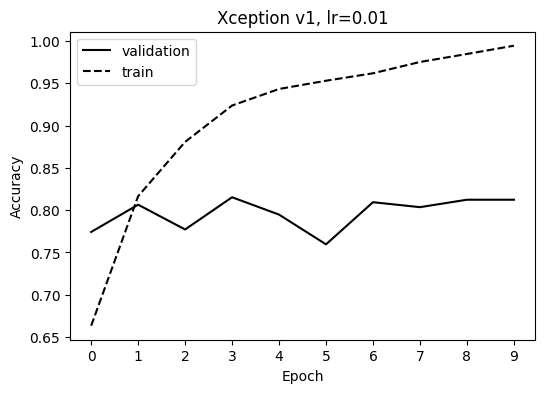

In [26]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()


# plt.savefig('xception_v1_0_01.svg')

plt.show()

Для валидационного множества уровень accuracy остается равным приблизительно 80%

### Настройка скорости обучения:

In [27]:
# Переписываем функцию для создания модели:

def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

Пробуем обучить при learning_rate = 0.001

In [28]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 471ms/step - accuracy: 0.5054 - loss: 1.4592 - val_accuracy: 0.7654 - val_loss: 0.7174
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 469ms/step - accuracy: 0.7854 - loss: 0.6287 - val_accuracy: 0.7859 - val_loss: 0.6423
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 461ms/step - accuracy: 0.8286 - loss: 0.5131 - val_accuracy: 0.8035 - val_loss: 0.5896
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 571ms/step - accuracy: 0.8742 - loss: 0.4111 - val_accuracy: 0.8240 - val_loss: 0.5610
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 602ms/step - accuracy: 0.9055 - loss: 0.3513 - val_accuracy: 0.8270 - val_loss: 0.5432
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 584ms/step - accuracy: 0.9196 - loss: 0.3058 - val_accuracy: 0.8211 - val_loss: 0.5306
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 519ms/step - accuracy: 0.9242 - loss: 0.2804 - val_accuracy: 0.8270 - val_loss: 0.5341
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 52s 536ms/step - accuracy: 0.9287 - loss: 0.2665 - val_accu

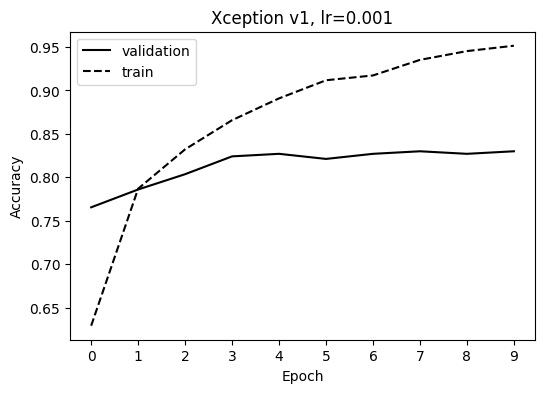

In [29]:
# Отрисовываем: 

plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


# plt.savefig('xception_v1_0_001.svg')

plt.show()

Пробуем обучить при learning_rate = 0.0001

In [30]:
model = make_model(learning_rate=0.0001)
history_0_0001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 513ms/step - accuracy: 0.2475 - loss: 2.1432 - val_accuracy: 0.5220 - val_loss: 1.5746
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 516ms/step - accuracy: 0.5404 - loss: 1.4362 - val_accuracy: 0.6422 - val_loss: 1.2316
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 474ms/step - accuracy: 0.6411 - loss: 1.1470 - val_accuracy: 0.7097 - val_loss: 1.0570
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 554ms/step - accuracy: 0.6777 - loss: 1.0196 - val_accuracy: 0.7331 - val_loss: 0.9521
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 576ms/step - accuracy: 0.7217 - loss: 0.9122 - val_accuracy: 0.7507 - val_loss: 0.8806
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 544ms/step - accuracy: 0.7307 - loss: 0.8457 - val_accuracy: 0.7742 - val_loss: 0.8253
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 500ms/step - accuracy: 0.7493 - loss: 0.7786 - val_accuracy: 0.7859 - val_loss: 0.7882
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 549ms/step - accuracy: 0.7552 - loss: 0.7523 - val_accu

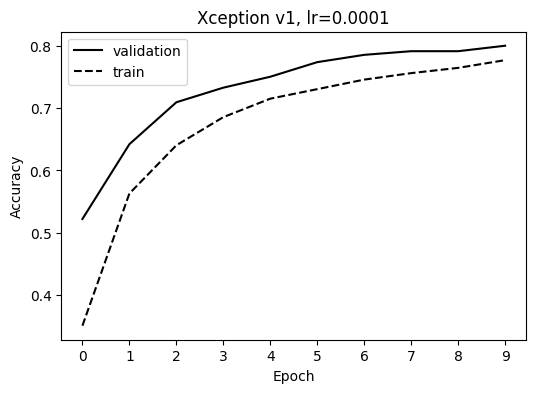

In [31]:
plt.figure(figsize=(6, 4))

epochs = history_0_0001.epoch
val = history_0_0001.history['val_accuracy']
train = history_0_0001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.0001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


# plt.savefig('xception_v1_0_0001.svg')

plt.show()

Объединяем результаты:

In [32]:
epochs = np.arange(10)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

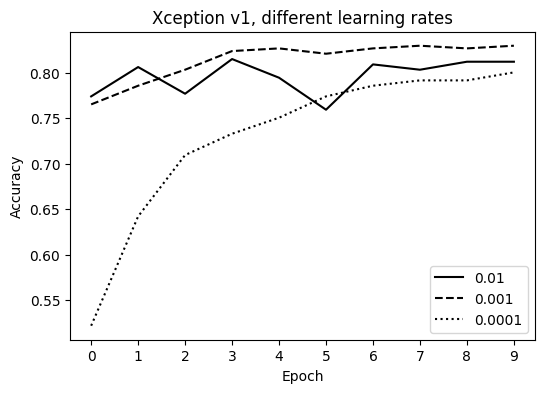

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('Xception v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

# plt.savefig('xception_v1_all_lr.svg')

plt.show()

Разница между 0.01 и 0.001 несущественна

### Сохранение модели:

Как только модель обучена, мы можем сохранить ее, используя метод save_weights:

In [ ]:
# model.save_weights(
#     'xception_v1_model.h5', # Выходной файл
#     save_format='h5' # Его формат
# )

Для того, чтобы сохранить лучшую модель, мы можем использовать метод callback и специальный класс ModelCheckpoint. 

ModelCheckpoint отслеживает наилучшую достоверность и сохраняет результаты на диск каждый раз, когда она повышается. 


In [34]:
model = make_model(learning_rate=0.001)

In [35]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(
    train_ds, 
    epochs=10,
    validation_data=val_ds, 
    callbacks=callbacks  # Определяет список обратных вызовов, которые будут использоваться во время обучения
)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 52s 524ms/step - accuracy: 0.5077 - loss: 1.4924 - val_accuracy: 0.7595 - val_loss: 0.7261
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 531ms/step - accuracy: 0.7784 - loss: 0.6535 - val_accuracy: 0.7977 - val_loss: 0.6300
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 52s 538ms/step - accuracy: 0.8278 - loss: 0.5250 - val_accuracy: 0.7918 - val_loss: 0.6094
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 470ms/step - accuracy: 0.8741 - loss: 0.4121 - val_accuracy: 0.8065 - val_loss: 0.5741
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 482ms/step - accuracy: 0.8843 - loss: 0.3691 - val_accuracy: 0.8094 - val_loss: 0.5677
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 480ms/step - accuracy: 0.9067 - loss: 0.3339 - val_accuracy: 0.7947 - val_loss: 0.5608
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 468ms/step - accuracy: 0.9228 - loss: 0.2891 - val_accuracy: 0.8211 - val_loss: 0.5559
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 489ms/step - accuracy: 0.9342 - loss: 0.2535 - val_accu

Поскольку обратный вызов ModelCheckpoint сохраняет модель, только когда она улучшается, у нас получилось 6 файлов с нашей моделью вместо десяти

### Добавление дополнительных слоев

Ранее мы обучили модель с одним плотных слоем:
 - outputs = keras.layers.Dense(10)(vector)

Теперь попробуем добавить еще один плотный слой между векторным представлением и выводом

In [36]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)  # добавляет еще один слой размером 100
    drop = keras.layers.Dropout(droprate)(inner) # Слой с отсевом и настраиваемой частотой 

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

Попробуем обучить модель с 4 разными частотами droprate:
- 0.0 - ничего не замораживается
- 0.2 - замораживается 20% слоя
- 0.5 - замораживается половина
- 0.8 - замораживается 80% слоя

In [42]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0 = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=callbacks
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 52s 529ms/step - accuracy: 0.5902 - loss: 1.2323 - val_accuracy: 0.7859 - val_loss: 0.6418
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 52s 538ms/step - accuracy: 0.8395 - loss: 0.4647 - val_accuracy: 0.8006 - val_loss: 0.5914
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 528ms/step - accuracy: 0.8737 - loss: 0.3435 - val_accuracy: 0.8182 - val_loss: 0.5518
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 576ms/step - accuracy: 0.9393 - loss: 0.2301 - val_accuracy: 0.8065 - val_loss: 0.5660
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 474ms/step - accuracy: 0.9511 - loss: 0.1651 - val_accuracy: 0.8123 - val_loss: 0.5949
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 475ms/step - accuracy: 0.9763 - loss: 0.1142 - val_accuracy: 0.8123 - val_loss: 0.5878
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 473ms/step - accuracy: 0.9926 - loss: 0.0690 - val_accuracy: 0.8123 - val_loss: 0.6286
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 483ms/step - accuracy: 0.9946 - loss: 0.0555 - val_accu

In [43]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=callbacks
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 461ms/step - accuracy: 0.5451 - loss: 1.4033 - val_accuracy: 0.7713 - val_loss: 0.7326
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 497ms/step - accuracy: 0.7887 - loss: 0.6220 - val_accuracy: 0.8152 - val_loss: 0.5835
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - accuracy: 0.8527 - loss: 0.4409 - val_accuracy: 0.8006 - val_loss: 0.5781
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 453ms/step - accuracy: 0.8768 - loss: 0.3603 - val_accuracy: 0.8270 - val_loss: 0.5616
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 452ms/step - accuracy: 0.8964 - loss: 0.3099 - val_accuracy: 0.8182 - val_loss: 0.5671
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - accuracy: 0.9312 - loss: 0.2280 - val_accuracy: 0.8123 - val_loss: 0.5688
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - accuracy: 0.9530 - loss: 0.1825 - val_accuracy: 0.8152 - val_loss: 0.5468
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - accuracy: 0.9592 - loss: 0.1482 - val_accu

In [45]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=callbacks
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 493ms/step - accuracy: 0.4708 - loss: 1.6054 - val_accuracy: 0.7361 - val_loss: 0.7702
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.7097 - loss: 0.8715 - val_accuracy: 0.7889 - val_loss: 0.6529
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 450ms/step - accuracy: 0.7482 - loss: 0.6976 - val_accuracy: 0.7889 - val_loss: 0.6054
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 453ms/step - accuracy: 0.7913 - loss: 0.5857 - val_accuracy: 0.8094 - val_loss: 0.5568
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - accuracy: 0.8224 - loss: 0.4944 - val_accuracy: 0.8094 - val_loss: 0.5515
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 452ms/step - accuracy: 0.8428 - loss: 0.4549 - val_accuracy: 0.8006 - val_loss: 0.5611
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - accuracy: 0.8543 - loss: 0.4073 - val_accuracy: 0.8035 - val_loss: 0.5513
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 462ms/step - accuracy: 0.8671 - loss: 0.3761 - val_accu

In [46]:
model = make_model(learning_rate=0.001, droprate=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=callbacks
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 469ms/step - accuracy: 0.3180 - loss: 2.1046 - val_accuracy: 0.6158 - val_loss: 1.1673
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 464ms/step - accuracy: 0.4997 - loss: 1.4476 - val_accuracy: 0.6862 - val_loss: 1.0142
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 453ms/step - accuracy: 0.5375 - loss: 1.3327 - val_accuracy: 0.7155 - val_loss: 0.9026
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 467ms/step - accuracy: 0.5775 - loss: 1.1963 - val_accuracy: 0.7361 - val_loss: 0.8473
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 473ms/step - accuracy: 0.5819 - loss: 1.1282 - val_accuracy: 0.7449 - val_loss: 0.7671
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - accuracy: 0.6210 - loss: 1.0974 - val_accuracy: 0.7654 - val_loss: 0.7691
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 466ms/step - accuracy: 0.6132 - loss: 1.0589 - val_accuracy: 0.7742 - val_loss: 0.7423
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 465ms/step - accuracy: 0.6253 - loss: 1.0344 - val_accu

In [47]:
# сохраняем результаты

epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']

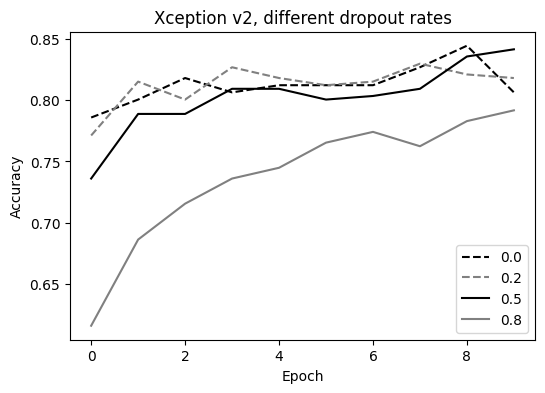

In [48]:
# отрисовываем

plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout.svg')

plt.show()

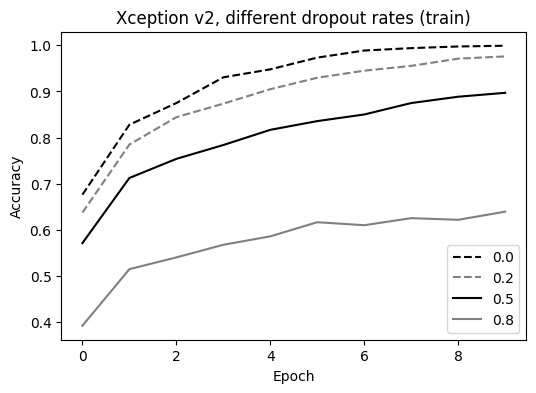

In [49]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout_train.svg')

plt.show()

Наилучший уровень отсева = 0.0